# Introduction

Muhammad Ryo Tjokrosoedomo<br>
FTDS Batch 10

Informasi dataset:<br>
- AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
- The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. 
- Every sample contain news title, news description, and label. The label consist of:
  - World (1) 
  - Sports (2)
  - Business (3) 
  - Sci/Tech (4).

Objective: Membuat model untuk melakukan klasifikasi subjek berita berdasarkan judul dan desktripsi berita

# Import Libraries

In [29]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf
import nltk
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Dropout, LSTM, GRU, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

np.random.seed(1)
tf.random.set_seed(1)

# Data Loading

In [2]:
drive.mount('/content/gdrive')
% cd /content/gdrive/My Drive/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [3]:
% cd /content/gdrive/MyDrive/Hacktiv8/Phase_2/Milestone_2/ag_news_csv

/content/gdrive/MyDrive/Hacktiv8/Phase_2/Milestone_2/ag_news_csv


In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [5]:
df_train.head()

,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
0,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
1,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
2,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
3,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
4,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...


In [6]:
df_test.head()

,3,Fears for T N pension after talks,Unions representing workers at Turner Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
0,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
1,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
2,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
3,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
4,4,Open Letter Against British Copyright Indoctri...,The British Department for Education and Skill...


Pengecekan missing value dan tipe data

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119999 entries, 0 to 119998
Data columns (total 3 columns):
 #   Column                                                                                          Non-Null Count   Dtype 
---  ------                                                                                          --------------   ----- 
 0   3                                                                                               119999 non-null  int64 
 1   Wall St. Bears Claw Back Into the Black (Reuters)                                               119999 non-null  object
 2   Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.  119999 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7599 entries, 0 to 7598
Data columns (total 3 columns):
 #   Column                                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                                           --------------  ----- 
 0   3                                                                                                                                7599 non-null   int64 
 1   Fears for T N pension after talks                                                                                                7599 non-null   object
 2   Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.  7599 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.2+ KB


Menambahkan nama kolom Label, Title, dan Description

In [9]:
df_train.columns =["Label", 'Title', 'Description']
df_test.columns =["Label", 'Title', 'Description']

df_train["Label"] = df_train["Label"].replace({1:0,2:1,3:2,4:3})
df_test["Label"] = df_test["Label"].replace({1:0,2:1,3:2,4:3})

In [10]:
df_train["Title"]

0         Carlyle Looks Toward Commercial Aerospace (Reu...
1           Oil and Economy Cloud Stocks' Outlook (Reuters)
2         Iraq Halts Oil Exports from Main Southern Pipe...
3         Oil prices soar to all-time record, posing new...
4               Stocks End Up, But Near Year Lows (Reuters)
                                ...                        
119994    Pakistan's Musharraf Says Won't Quit as Army C...
119995                    Renteria signing a top-shelf deal
119996                      Saban not going to Dolphins yet
119997                                    Today's NFL games
119998                         Nets get Carter from Raptors
Name: Title, Length: 119999, dtype: object

Menggabungkan kolom Title dan Description menjadi Input agar bisa diproses dalam model

In [11]:
df_train["Input"] = df_train["Title"] + " " + df_train["Description"]
df_test["Input"] = df_test["Title"] + " " + df_test["Description"]

Pengecekan statistika deskriptif

In [12]:
df_train.describe(include='all')

,Label,Title,Description,Input
count,119999.000000,119999,119999,119999
unique,NaN,114363,118730,119999
top,NaN,Today's schedule,"With the economy slowly turning up, upgrading ...",Carlyle Looks Toward Commercial Aerospace (Reu...
freq,NaN,39,15,1
mean,1.499996,NaN,NaN,NaN
std,1.118042,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,0.500000,NaN,NaN,NaN
50%,1.000000,NaN,NaN,NaN
75%,2.500000,NaN,NaN,NaN


- Terdapat 114363 nilai unik pada fitur Title, dimana yang terbanyak adalah "Today's shedule" sebanyak 39 data
- Terdapat 118730 nilai unik pada fitur Description, dimana yang terbanyak adalah "With the economy slowly turning up, upgrading hardware has been on businesses radar in the past 12 months as their number two priority." sebanyak 15 data

In [13]:
df_train[df_train["Title"] == "Today's schedule"]

,Label,Title,Description,Input
1309,1,Today's schedule,Pro baseball: Red Sox vs. Toronto at Fenway Pa...,Today's schedule Pro baseball: Red Sox vs. Tor...
6333,1,Today's schedule,Pro baseball: Eastern League -- Trenton vs. Po...,Today's schedule Pro baseball: Eastern League ...
15428,1,Today's schedule,Amateur baseball: Yawkey League playoffs -- So...,Today's schedule Amateur baseball: Yawkey Leag...
16065,1,Today's schedule,College basketball: MEN -- Boston University a...,Today's schedule College basketball: MEN -- Bo...
16249,1,Today's schedule,Amateur baseball: Yawkey League playoffs -- So...,Today's schedule Amateur baseball: Yawkey Leag...
17452,1,Today's schedule,Pro baseball: Texas vs. Red Sox at Fenway Park...,Today's schedule Pro baseball: Texas vs. Red S...
18398,1,Today's schedule,Pro baseball: Red Sox vs. Texas at Fenway Park...,Today's schedule Pro baseball: Red Sox vs. Tex...
19545,1,Today's schedule,Pro baseball: International League -- Pawtucke...,Today's schedule Pro baseball: International L...
23503,1,Today's schedule,College field hockey: Quinnipiac at Northeaste...,Today's schedule College field hockey: Quinnip...
29416,1,Today's schedule,Pro baseball: Tampa Bay vs. Red Sox at Fenway ...,Today's schedule Pro baseball: Tampa Bay vs. R...


In [14]:
df_train[df_train["Description"] == "With the economy slowly turning up, upgrading hardware has been on businesses radar in the past 12 months as their number two priority."]

,Label,Title,Description,Input
24151,3,"For Intel, the future has two cores","With the economy slowly turning up, upgrading ...","For Intel, the future has two cores With the e..."
24640,3,New BlackBerry features smaller keyboard,"With the economy slowly turning up, upgrading ...",New BlackBerry features smaller keyboard With ...
26094,3,Lower orders dent Broadcom #39;s outlook,"With the economy slowly turning up, upgrading ...",Lower orders dent Broadcom #39;s outlook With ...
27259,3,Nokia joins secure digital memory card group,"With the economy slowly turning up, upgrading ...",Nokia joins secure digital memory card group W...
30878,3,Voq smartphone arrives in US,"With the economy slowly turning up, upgrading ...",Voq smartphone arrives in US With the economy ...
31247,2,IBM settles part of giant pension lawsuit,"With the economy slowly turning up, upgrading ...",IBM settles part of giant pension lawsuit With...
33388,3,Comdial extends SIP to branch offices,"With the economy slowly turning up, upgrading ...",Comdial extends SIP to branch offices With the...
33483,2,PMC-Sierra lowers forecast,"With the economy slowly turning up, upgrading ...",PMC-Sierra lowers forecast With the economy sl...
34761,3,Study: MP3 player market to explode,"With the economy slowly turning up, upgrading ...",Study: MP3 player market to explode With the e...
34806,3,Mitsubishi pulling out of large LCDs,"With the economy slowly turning up, upgrading ...",Mitsubishi pulling out of large LCDs With the ...


# Exploratory Data Analysis

Melihat distribusi jumlah huruf pada fitur Title

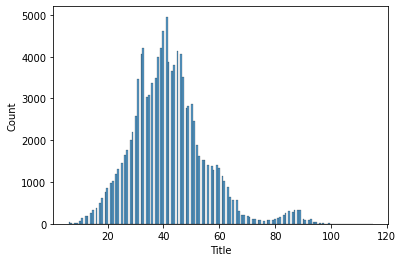

In [15]:
sns.histplot(df_train['Title'].str.len()) # histogram jumlah huruf (karakter)

Jumlah huruf 40 adalah yang terbanyak pada fitur Title

Melihat distribusi jumlah huruf pada fitur Description

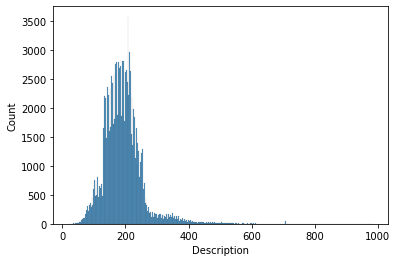

In [188]:
sns.histplot(df_train['Description'].str.len()) # histogram jumlah huruf (karakter)

Jumlah huruf 200 adalah yang terbanyak pada fitur Description

Melihat distribusi jumlah kata pada fitur Title

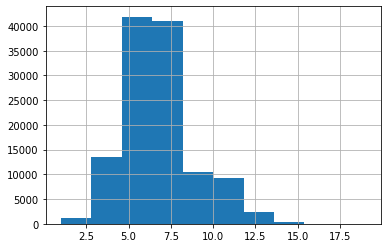

In [17]:
df_train["Title"].str.split().map(lambda x: len(x)).hist()

Jumlah kata 6 adalah yang terbanyak pada fitur Title

Melihat distribusi jumlah kata pada fitur Description

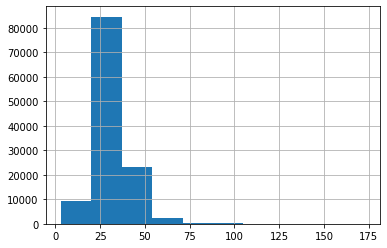

In [190]:
df_train["Description"].str.split().map(lambda x: len(x)).hist()

Jumlah kata 25 adalah yang terbanyak pada fitur Title

Melihat distribusi jumlah Label

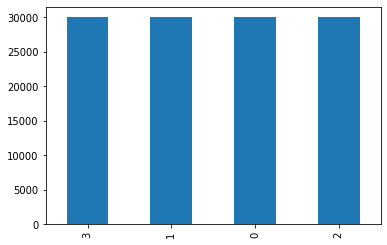

In [18]:
df_train["Label"].value_counts().plot(kind="bar")

Train dataset memiliki jumlah label yang seimbang, setiap labelnya berjumlah 30000

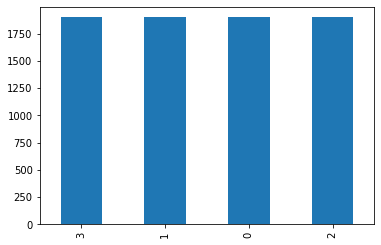

In [19]:
df_test["Label"].value_counts().plot(kind="bar")

Test dataset memiliki jumlah label yang seimbang, setiap labelnya berjumlah 1900

Menggunakan wordcloud untuk melihat kata apa yang paling banyak muncul

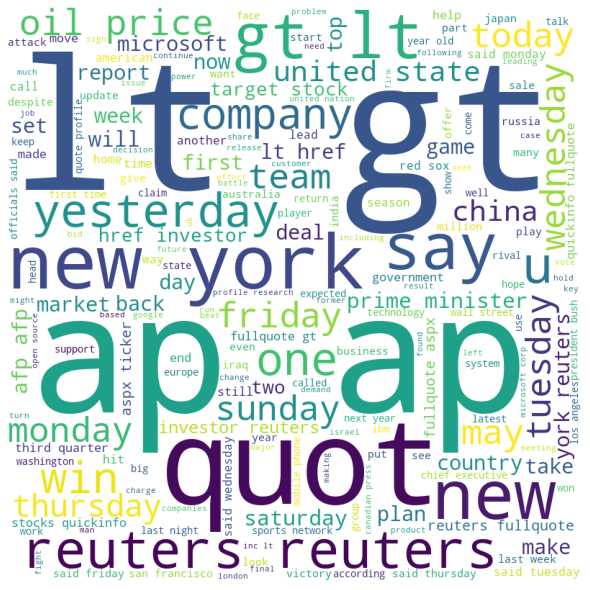

In [21]:
comment_words = ''
stopwords = set(STOPWORDS)

for val in df_train.Input:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

- kata "ap", "lt", dan "gt" yang banyak muncul akan dicek lebih lanjut
- reuters merupakan kata yang paling banyak muncul selain ap, lt, dan gt

In [22]:
# def generate_wordcloud(df,col,i,label):
    
#     data = df[df.label == i][col].values
    
#     wc = WordCloud(stopwords=STOPWORDS, background_color='black',
#                    max_words=10000, min_font_size=6, min_word_length=1)
#     wc.generate(' '.join(data))
    
#     plt.figure(figsize=(15,15))
#     plt.title('WordCloud for {}'.format(label), fontsize = 24)
#     plt.imshow(wc)
#     plt.axis("off")
#     plt.show()
    


# labels = np.unique(df_train.label.values)
# label_names = ['Bug','Feature','Question']
# for i in labels:
#     generate_wordcloud(df_train,'body',i,label_names[i])

In [23]:
df_train.Description.sample(20, random_state=70)

90418     AP - Washington's super-close governor's race ...
93995     The company's latest earnings met analysts' es...
75773     Jos Manuel Duro Barroso, the incoming presiden...
36531     A Senate committee voted yesterday to transfer...
87228     The update for the e-mail program focuses main...
58069     AFP - Royal Dutch/Shell plans to auction off i...
102505    Mitsubishi Motors Corp. said it will sell \$2 ...
91089     Technology News, A new front has been opened i...
70466     FOSTER #39;S Group chief executive Trevor O #3...
40582     KUALA LUMPUR: Organisations around the world a...
108320     SEVILLE, Spain (Reuters) - Teenage rookie Raf...
21952      NEW YORK (Reuters) - Avon Products Inc. &lt;A...
68105     Reuters - Intel Corp.  on Thursday\said it has...
65259     Celtic captain Jackie McNamara admits even if ...
20282     ST. PAUL, Minn. - A winner of the World Cup of...
109235    The European Commission is to back former EU t...
105496    Princess Diana continues to fa

In [24]:
df_train.iloc[21952,2]

' NEW YORK (Reuters) - Avon Products Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=AVP.N target=/stocks/quickinfo/fullquote"&gt;AVP.N&lt;/A&gt;, the  world\'s largest direct seller of cosmetics, on Wednesday  forecast a slide of as much as 10 percent in U.S. operating  profit as it grapples with weaker sales of key beauty items.'

"ap", "lt", dan "gt" tersebut tidak memiliki informasi didalamnya dan akan dihapus

# Data Preprocessing

Menggunakan library nltk untuk preprocessing data

stopwords digunakan untuk menghapus kata-kata yang umum ada pada bahasa inggris

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
stop = stopwords.words('english')

In [32]:
df_train['Input'] = df_train['Input'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

53201     Minority Liberals oppose Bloc amendment, put g...
55374     Montana Moves Resume Bison Hunting (AP) AP - O...
47257     Fleeing Ennui Retirement Thrill Fight elix Tri...
28373     Crews Fail Find Tree-Killing Beetle (AP) AP - ...
23384     Ruling turns heat PeopleSoft Takeover battle l...
23401     Bush, Kerry feud Vietnam, economy, Iraq, Darfu...
12114     Preston Heads Home Preston, Md. ended run Litt...
102977    No. 10 Boise St. Wins 22nd Straight Game (AP) ...
46029     A breakthrough could works By now, every Aggie...
104136    Sony Unprepared Flat TV Demand LONDON (Reuters...
Name: Input, dtype: object

Membuat semua huruf menjadi huruf kecil, menghilangkan tanda baca, dan angka<br>

In [33]:
# ap, lt, gt juga harus dihilangkan lewat fungsi ini
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\(.*?\)', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\d+', '', text)
    text = re.sub('(\s)&lt;.*&gt;(\s)', '', text)
    text = re.sub('(\s)ap(\s)', '', text)
    text = re.sub('(\s)ltbgtltbgt(\s)', '', text)
    text = re.sub('(\s)&quot;(\s)', '', text)
    text = re.sub('(\s)quot(\s)', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [34]:
df_train['Input'] = df_train['Input'].apply(round1)

0         carlyle looks toward commercial aerospace  reu...
1         oil economy cloud stocks outlook  reuters  soa...
2         iraq halts oil exports main southern pipeline ...
3         oil prices soar alltime record posing new mena...
4         stocks end up but near year lows  reuters  sto...
                                ...                        
119994    pakistans musharraf says wont quit army chief ...
119995    renteria signing topshelf deal red sox general...
119996    saban going dolphins yet the miami dolphins pu...
119997    todays nfl games pittsburgh ny giants time  pm...
119998    nets get carter raptors indianapolis  allstar ...
Name: Input, Length: 119999, dtype: object

Menggunakan PorterStemmer untuk mengubah kata turunan menjadi kata dasarnya

In [36]:
ps = PorterStemmer()

df_train['Input'] = df_train['Input'].apply(ps.stem)

Mengecek kembali kata yang sering muncul setelah di preprocess

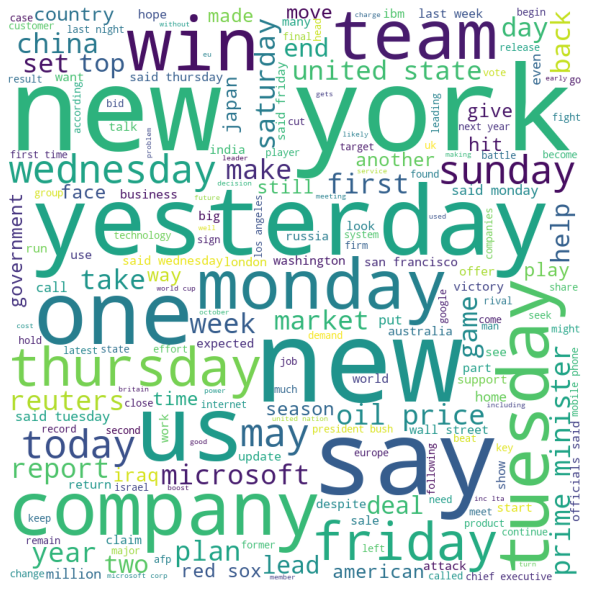

In [38]:
comment_words = ''
stopwords = set(STOPWORDS)

for val in df_train.Input:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

- ap, lt, dan gt sudah hilang
- Beberapa kata yang paling sering muncul adalah yesterday, company, monday, dan say

Membuat sampel untuk data inference

In [39]:
df_inf = df_test.sample(10, random_state=8)
df_inf

,Label,Title,Description,Input
3768,2,Accounting body delays rule on expensing options,"Bowing to corporate pressure, the group that s...",Accounting body delays rule on expensing optio...
5063,2,"SIA: Chip sales to hit record, flatten",Worldwide semiconductor sales will hit an all-...,"SIA: Chip sales to hit record, flatten Worldwi..."
3332,0,Blair: Time for Excuses on Africa Is Over (Reu...,Reuters - British Prime Minister\Tony Blair is...,Blair: Time for Excuses on Africa Is Over (Reu...
4130,3,Soy-Fertility Risk Downplayed,(WebMD) Eating a diet rich in soy or taking so...,Soy-Fertility Risk Downplayed (WebMD) Eating a...
3663,3,Oracle vs. PeopleSoft: Lies and Lying CEOs Who...,PeopleSoft #39;s board knew that CEO Craig Con...,Oracle vs. PeopleSoft: Lies and Lying CEOs Who...
6113,0,UN deadlock defeats cloning ban,The United Nations has shelved efforts to draf...,UN deadlock defeats cloning ban The United Nat...
1103,3,Apple faithful's apathy to blame for Napsteriz...,&lt;strong&gt;Opinion&lt;/strong&gt; Impotent ...,Apple faithful's apathy to blame for Napsteriz...
5062,2,Constellation gets Mondavi for \$1.36B,"CHICAGO (CBS.MW) - By upping the ante a bit, C...",Constellation gets Mondavi for \$1.36B CHICAGO...
2537,1,Soccer: Vller quits Roma after Bologna loss,Rudi Vller said Sunday that he had left Roma o...,Soccer: Vller quits Roma after Bologna loss Ru...
1174,1,Tom Ridge sets all-age record in winning World...,Tom Ridge set an all-age record of 1 minute 50...,Tom Ridge sets all-age record in winning World...


split train-val-test

In [40]:
# siapkan label

X_train = df_train["Input"]
y_train = df_train["Label"]

X_test = df_test["Input"]
y_test = df_test["Label"]

X_test, X_val = train_test_split(X_test, test_size=0.2, random_state=23)
y_test, y_val = train_test_split(y_test, test_size=0.2, random_state=23)

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

Tokenisasi per kata menggunakan TextVectorization

In [120]:
## tokenisasi
# Setup vectorization
max_vocab_length = 115000
max_length = 25

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_length,
                                       input_shape=(1,))

In [121]:
text_vectorization.adapt(X_train)

Embedding dataset

In [134]:
# Embedding
embed = Embedding(input_dim=max_vocab_length,
                  output_dim=128,
                  embeddings_initializer="uniform",
                  input_length=max_length,
                  mask_zero=True
                  )

# embedding_trainable=False <- supaya embedding tidak berubah setiap training dilakukan

In [172]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_ohe)).batch(1000)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_ohe)).batch(1000)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_ohe)).batch(1000)

# Model Definition

Membuat arsitektur model neural network RNN menggunakan LSTM

1. Base Model

In [173]:
# callbacks
callbacks= [
    EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
]

In [174]:
# Fully Connected Layer

base_model = Sequential()
base_model.add(text_vectorization)
base_model.add(embed)
base_model.add(LSTM(512, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6),return_sequences=True))
base_model.add(Dropout(0.4))
base_model.add(BatchNormalization())
base_model.add(LSTM(128, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6), return_sequences=True))
base_model.add(Dropout(0.4))
base_model.add(BatchNormalization())
base_model.add(LSTM(50, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6), return_sequences=True))
base_model.add(Dropout(0.4))
base_model.add(BatchNormalization())
base_model.add(LSTM(16, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6), return_sequences=False))
base_model.add(Dropout(0.4))
base_model.add(BatchNormalization())
base_model.add(Dense(8, activation="relu"))
base_model.add(Dropout(0.4))
base_model.add(Dense(4, activation="softmax"))

2. Improved Model

In [175]:
# Fully Connected Layer

imp_model = Sequential()
imp_model.add(text_vectorization)
imp_model.add(embed)
# model.add(GRU(512, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())
# model.add(LSTM(128, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6), return_sequences=True))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())
imp_model.add(LSTM(40, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6), return_sequences=True))
imp_model.add(Dropout(0.4))
imp_model.add(BatchNormalization())
imp_model.add(LSTM(16, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6), return_sequences=False))
imp_model.add(Dropout(0.4))
imp_model.add(BatchNormalization())
imp_model.add(Dense(8, activation="relu"))
imp_model.add(Dropout(0.4))
imp_model.add(Dense(4, activation="softmax"))

# Model Training

Training base model

In [176]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [177]:
base_model_history = base_model.fit(train_ds,
                            epochs=100,
                            callbacks=callbacks,
                            validation_data=val_ds)

Epoch 1/100
120/120 [==============================] - 34s 158ms/step - loss: 0.6608 - accuracy: 0.7703 - val_loss: 0.9299 - val_accuracy: 0.7717
Epoch 2/100
120/120 [==============================] - 15s 121ms/step - loss: 0.4827 - accuracy: 0.8312 - val_loss: 0.6141 - val_accuracy: 0.8164
Epoch 3/100
120/120 [==============================] - 15s 124ms/step - loss: 0.4351 - accuracy: 0.8426 - val_loss: 0.5395 - val_accuracy: 0.8487
Epoch 4/100
120/120 [==============================] - 15s 123ms/step - loss: 0.3989 - accuracy: 0.8620 - val_loss: 0.5670 - val_accuracy: 0.8599
Epoch 5/100
120/120 [==============================] - 15s 123ms/step - loss: 0.3554 - accuracy: 0.8779 - val_loss: 0.6269 - val_accuracy: 0.8684
Epoch 6/100
120/120 [==============================] - 15s 123ms/step - loss: 0.3344 - accuracy: 0.8833 - val_loss: 0.8053 - val_accuracy: 0.8382
Epoch 6: early stopping


training improved model

In [178]:
imp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [179]:
imp_model_history = imp_model.fit(train_ds,
                            epochs=100,
                            callbacks=callbacks,
                            validation_data=val_ds)

Epoch 1/100
120/120 [==============================] - 13s 50ms/step - loss: 1.3445 - accuracy: 0.3645 - val_loss: 1.3539 - val_accuracy: 0.6059
Epoch 2/100
120/120 [==============================] - 4s 31ms/step - loss: 0.9872 - accuracy: 0.5776 - val_loss: 1.2218 - val_accuracy: 0.7664
Epoch 3/100
120/120 [==============================] - 4s 30ms/step - loss: 0.8464 - accuracy: 0.6523 - val_loss: 0.9930 - val_accuracy: 0.8112
Epoch 4/100
120/120 [==============================] - 4s 30ms/step - loss: 0.7585 - accuracy: 0.7043 - val_loss: 0.7620 - val_accuracy: 0.8441
Epoch 5/100
120/120 [==============================] - 4s 30ms/step - loss: 0.6952 - accuracy: 0.7356 - val_loss: 0.6150 - val_accuracy: 0.8618
Epoch 6/100
120/120 [==============================] - 4s 31ms/step - loss: 0.6409 - accuracy: 0.7588 - val_loss: 0.5332 - val_accuracy: 0.8724
Epoch 7/100
120/120 [==============================] - 4s 31ms/step - loss: 0.5996 - accuracy: 0.7739 - val_loss: 0.4972 - val_accuracy

# Model Evaluation

Mengecek performa model dengan membandingkan loss dengan val loss menggunakan grafik

1. Base Model

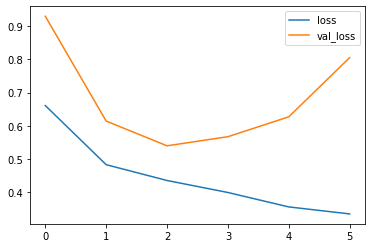

In [180]:
metrics = pd.DataFrame(base_model_history.history)
metrics[["loss", "val_loss"]].plot()

Terlihat model mengalami overfitting

2. Improved Model

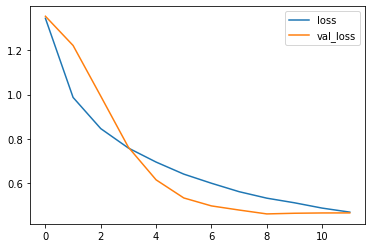

In [181]:
metrics = pd.DataFrame(imp_model_history.history)
metrics[["loss", "val_loss"]].plot()

Model sudah cukup baik

Membuat classification report

1. Base Model

In [182]:
from sklearn.metrics import classification_report
y_pred = base_model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1516
           1       0.97      0.81      0.88      1515
           2       0.76      0.85      0.80      1513
           3       0.79      0.85      0.82      1535

    accuracy                           0.83      6079
   macro avg       0.84      0.83      0.84      6079
weighted avg       0.84      0.83      0.84      6079



2. Improved Model

In [183]:
from sklearn.metrics import classification_report
y_pred = imp_model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1516
           1       0.93      0.91      0.92      1515
           2       0.86      0.78      0.82      1513
           3       0.80      0.88      0.84      1535

    accuracy                           0.86      6079
   macro avg       0.86      0.86      0.86      6079
weighted avg       0.86      0.86      0.86      6079



Classification report yang dihasilkan dari improved model seidkit memiliki peningkatan

# Model Saving

Save model tensorflow

In [184]:
imp_model.save("model_nn", save_format='tf')

# Model Inference

In [185]:
df_inf.reset_index(drop=True,inplace=True)

In [186]:
inf_pred = imp_model.predict(df_inf["Input"])
inf_pred = inf_pred.argmax(axis=1)
inf_pred_df = pd.DataFrame(inf_pred, columns=["Label prediction"])
inf_pred_df

,Label prediction
0,2
1,3
2,0
3,0
4,2
5,3
6,3
7,3
8,1
9,0


In [187]:
inf_pred_df.join(df_inf)

,Label prediction,Label,Title,Description,Input
0,2,2,Accounting body delays rule on expensing options,"Bowing to corporate pressure, the group that s...",Accounting body delays rule on expensing optio...
1,3,2,"SIA: Chip sales to hit record, flatten",Worldwide semiconductor sales will hit an all-...,"SIA: Chip sales to hit record, flatten Worldwi..."
2,0,0,Blair: Time for Excuses on Africa Is Over (Reu...,Reuters - British Prime Minister\Tony Blair is...,Blair: Time for Excuses on Africa Is Over (Reu...
3,0,3,Soy-Fertility Risk Downplayed,(WebMD) Eating a diet rich in soy or taking so...,Soy-Fertility Risk Downplayed (WebMD) Eating a...
4,2,3,Oracle vs. PeopleSoft: Lies and Lying CEOs Who...,PeopleSoft #39;s board knew that CEO Craig Con...,Oracle vs. PeopleSoft: Lies and Lying CEOs Who...
5,3,0,UN deadlock defeats cloning ban,The United Nations has shelved efforts to draf...,UN deadlock defeats cloning ban The United Nat...
6,3,3,Apple faithful's apathy to blame for Napsteriz...,&lt;strong&gt;Opinion&lt;/strong&gt; Impotent ...,Apple faithful's apathy to blame for Napsteriz...
7,3,2,Constellation gets Mondavi for \$1.36B,"CHICAGO (CBS.MW) - By upping the ante a bit, C...",Constellation gets Mondavi for \$1.36B CHICAGO...
8,1,1,Soccer: Vller quits Roma after Bologna loss,Rudi Vller said Sunday that he had left Roma o...,Soccer: Vller quits Roma after Bologna loss Ru...
9,0,1,Tom Ridge sets all-age record in winning World...,Tom Ridge set an all-age record of 1 minute 50...,Tom Ridge sets all-age record in winning World...


Masih terdapat kesalahan prediksi label, performa model masih dapat ditingkatkan

# Conclusions

- Dari grafik perbandingan loss vs val_loss, didapatkan hasil yang sudah cukup baik
- Dari hasil classification report walaupun label target memiliki jumlah yang seimbang, namun hanya label 1 yang memiliki performa baik, yaitu precision 0.93, recall 0.91, dan F1 score 0.92
- Label 0 dan 3 sudah cukup baik, dengan nilai recall dan precision di kisaran 0.8
- Label 2 masih perlu ditingkatkan karena nilai recallnya 0.78
- Arsitektur optimal untuk model ini adalah:
  - Batch size: 1000
  - Hidden layer 1: LSTM dengan jumlah neuron 40 dengan regularizer L1=1e-6 dan L2=1e-6. Dengan dropout 0.4 dan batch normalizer
  - Hidden layer 2: LSTM dengan jumlah neuron 16 dengan regularizer L1=1e-6 dan L2=1e-6. Dengan dropout 0.4 dan batch normalizer
  - Hidden layer 3: Dense dengan jumlah neuron 8 dan fungsi aktivasi relu. Dengan dropout 0.4
  - optimizer: adam, learning rate = 0.0001
  - epoch: 12
- Performa model masih bisa ditingkatkan mungkin dengan penggunaan pretrained model yang sudah ada